## importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

## importing data

In [3]:
url = "https://drive.google.com/file/d/1NLfDsLESwUevZuXCyJwFhRc6MmDHWJfz/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
music = pd.read_csv(path, sep =",")

## adressing the whitespaces in the column-names

In [4]:
music.columns = music.columns.str.replace(" ", "")

## dropping non-numeric values, the binary-value "mode" and "liveness" - the latter because live-songs may fit in every given playlist when the "tone" fits, only the special usecase of "live"-only playlists would be problematic

In [5]:
music.drop(["type", "duration_ms", "time_signature", "id", "html", "mode", "liveness"], axis=1, inplace=True )

## ignoring artist and title for scaling

In [6]:
prep_music = music.iloc[:, 2:]

In [7]:
minmax_music = MinMaxScaler().fit_transform(prep_music)

## setting artist/title as index

In [8]:
music.set_index(["artist", "name"], inplace=True)

## creating the dataframe with min-max-scaled values

In [36]:
mm_music = pd.DataFrame(minmax_music, columns=music.columns, index=music.index)

## the business-requirement asks for max 250 songs per cluster, given 5k+ tracks in the data-set, 20 is the minimum-threshold, thus analysing inertia for 20+ clusters

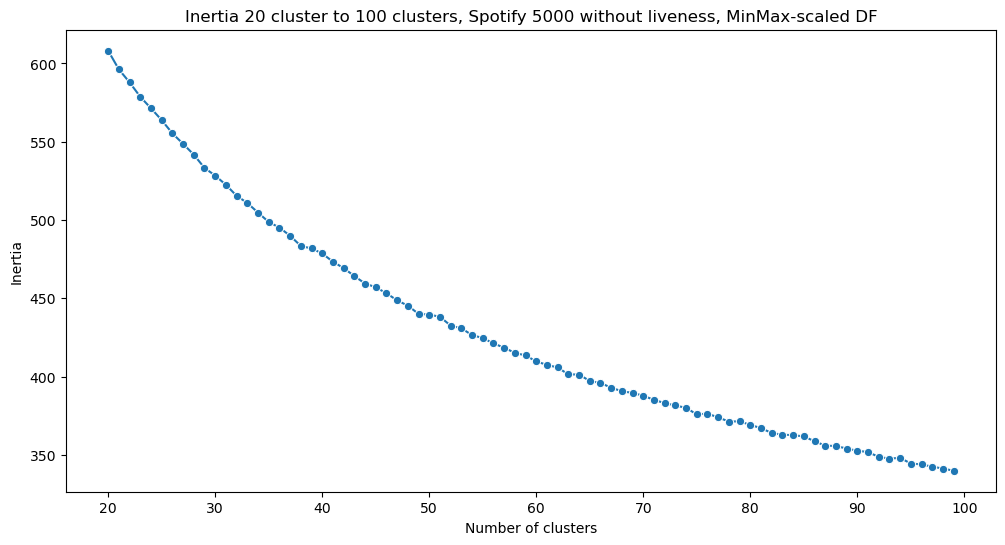

In [37]:
from sklearn.cluster import KMeans

max_k = 100
inertia = []

for k in range(20, max_k): 
    inertia.append(KMeans(n_clusters=k).fit(mm_music).inertia_)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Inertia 20 cluster to {max_k} clusters, Spotify 5000 without mode and liveness, MinMax-scaled DF')
sns.lineplot(x=range(20, max_k), y=inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

##  first exploration of silhouette showed good values for low 20ish and a local maximum between 30 and 40 (which was not reached with higher numbers of clusters), so identifying the max in that range

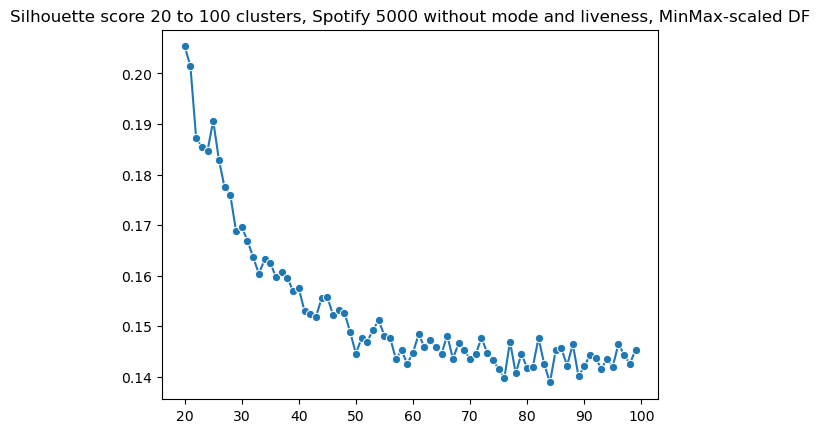

In [39]:
max_k = 100
sil_score = []

for k in range(20, max_k): 
    labels = KMeans(n_clusters=k).fit(mm_music).labels_
    sil_score.append(silhouette_score(mm_music, labels))

plt.title(f'Silhouette score 20 to {max_k} clusters, Spotify 5000 without mode and liveness, MinMax-scaled DF')
sns.lineplot(x=range(20, max_k), y=sil_score, marker='o')
plt.show()

## silhouette shows a local peak between 30 and 40

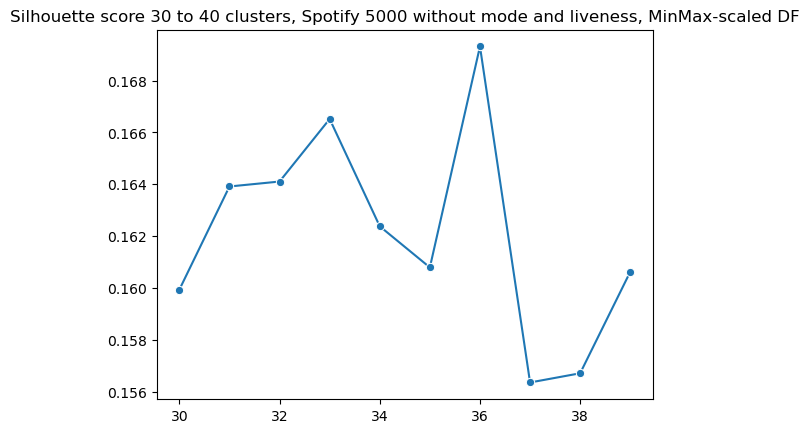

In [40]:
max_k = 40
sil_score = []

for k in range(30, max_k): 
    labels = KMeans(n_clusters=k).fit(mm_music).labels_
    sil_score.append(silhouette_score(mm_music, labels))

plt.title(f'Silhouette score 30 to {max_k} clusters, Spotify 5000 without mode and liveness, MinMax-scaled DF')
sns.lineplot(x=range(30, max_k), y=sil_score, marker='o')
plt.show()

## using the maximum at 36 clusters to calculate the kmeans

In [10]:
kmeans36 = KMeans(n_clusters=36)
kmeans36.fit(mm_music)  # Compute k-means clustering

KMeans(n_clusters=36)

## setting up a dataframe with the cluster centers

In [11]:
cluster_pos = pd.DataFrame(kmeans36.cluster_centers_, columns=music.columns)

## calculating the pairwise distances between the cluster centers

In [12]:
cluster_pos_e = pd.DataFrame(pairwise_distances(cluster_pos), index=cluster_pos.index, columns=cluster_pos.index)

## plotting the distances in a dataframe

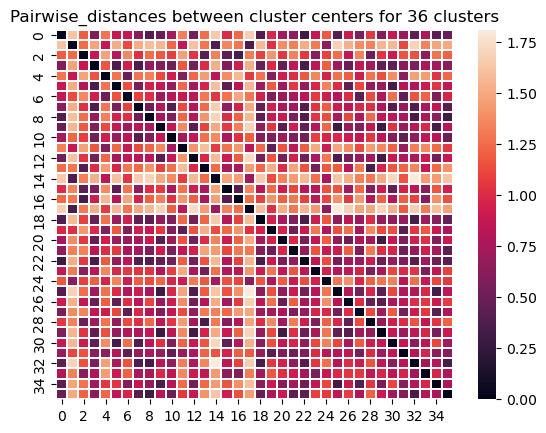

In [13]:
sns.heatmap(cluster_pos_e, linewidths=.2).set_title(f"Pairwise_distances between cluster centers for 36 clusters");

## inserting the column "cluster" in the min-maxed-dataframe

In [14]:
mm_music["cluster"] = kmeans36.labels_

In [15]:
mm_music.cluster.value_counts()

22    234
13    231
25    217
7     206
0     206
14    205
2     198
3     198
16    190
32    185
17    182
29    157
6     157
1     156
9     154
21    146
26    146
8     141
19    135
30    134
27    132
35    128
20    125
34    125
5     125
4     115
12    111
31    110
15    109
10     99
18     96
28     90
11     80
23     77
33     69
24     66
Name: cluster, dtype: int64

## setting up loops to draw samples from the clusters
- first take sample and reset index in order to drop the artist/title in the next step

In [16]:
sample_list = []
for i in range(36):
    x = mm_music[mm_music.cluster == i].sample(15).reset_index()
    sample_list.append(x)

In [17]:
sample_list = []
sample_list_full_df = []
for i in range(36):
    x = mm_music[mm_music.cluster == i].sample(n=15, random_state=1).reset_index()
    y = mm_music[mm_music.cluster == i].sample(n=15, random_state=1)
    sample_list.append(x)
    sample_list_full_df.append(y)

- calculating the pairwise distances between the songs in the samples

In [18]:
x_e_list = []
for a in sample_list:
    a.drop("artist", axis=1, inplace=True)
    a.drop("name", axis=1, inplace=True)
    x_e = pd.DataFrame(pairwise_distances(a), index=x.index, columns=x.index)
    x_e_list.append(x_e)

- plotting those in heatmaps

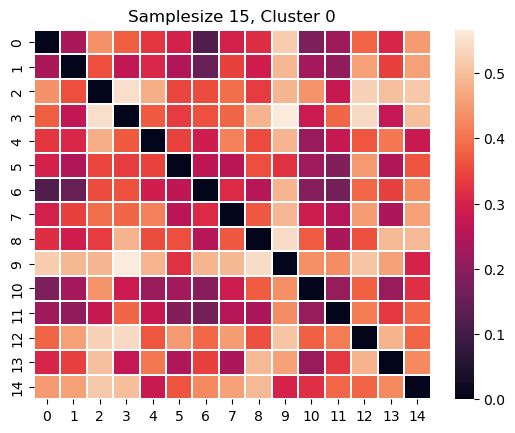

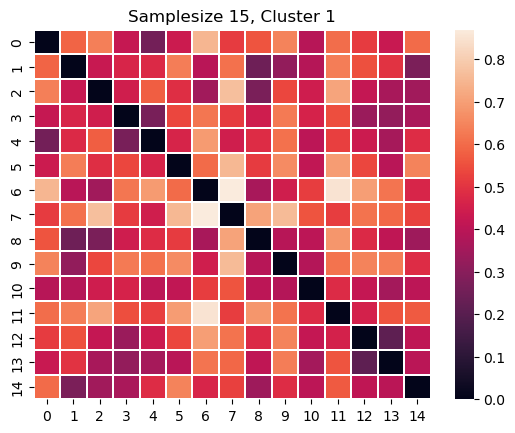

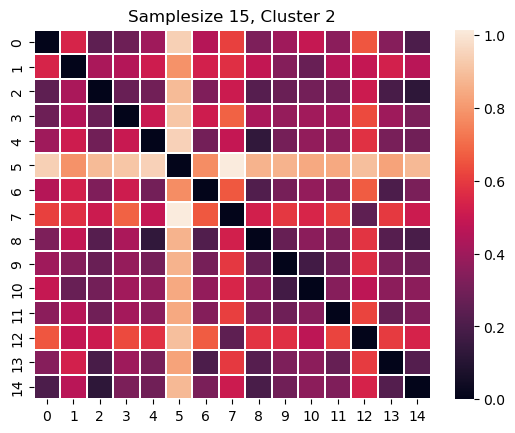

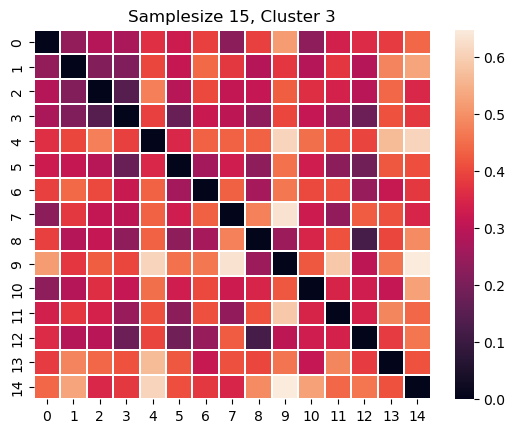

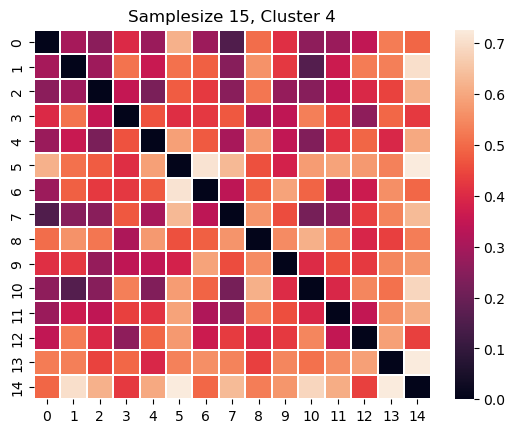

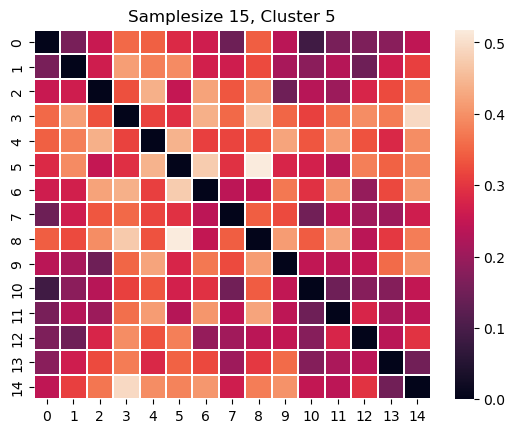

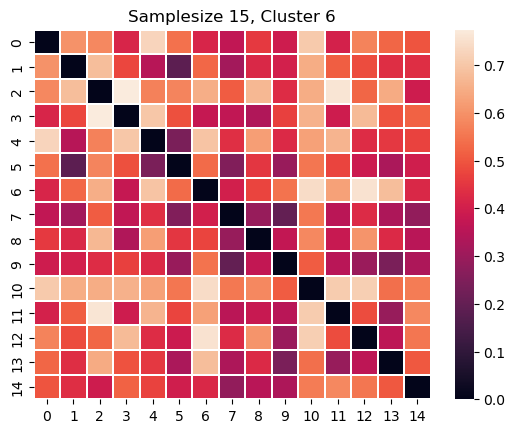

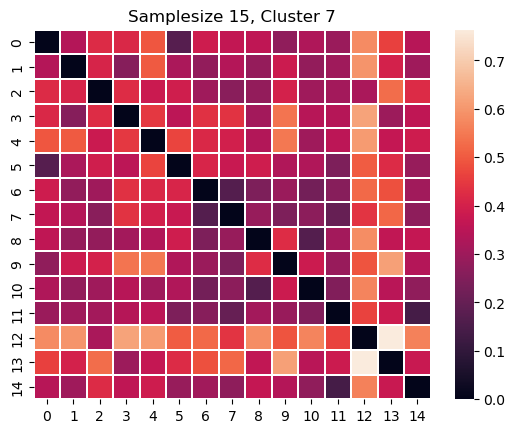

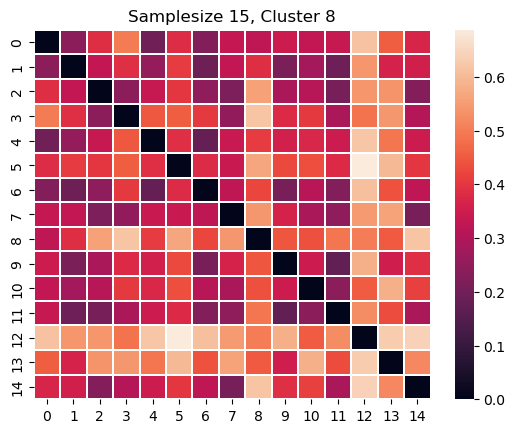

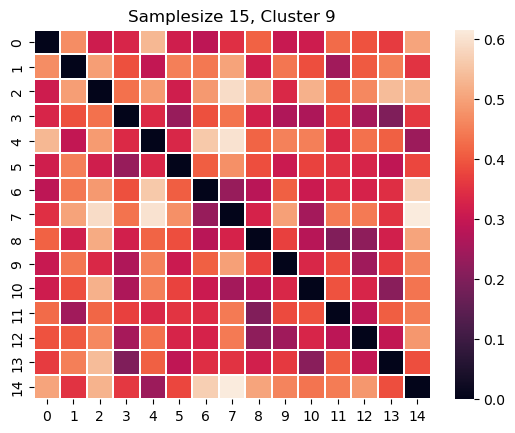

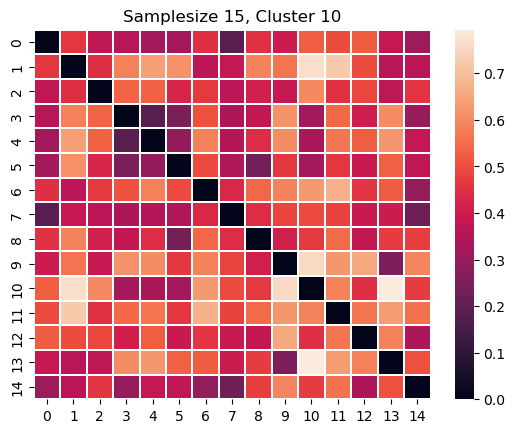

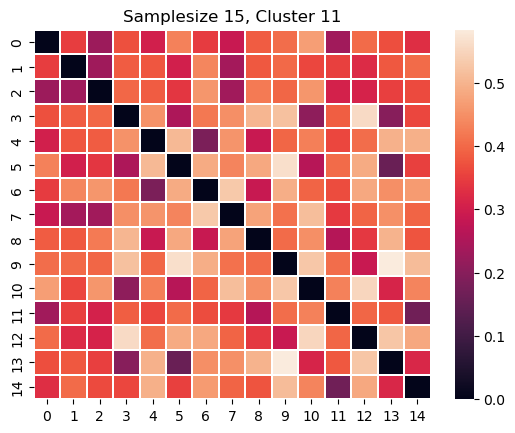

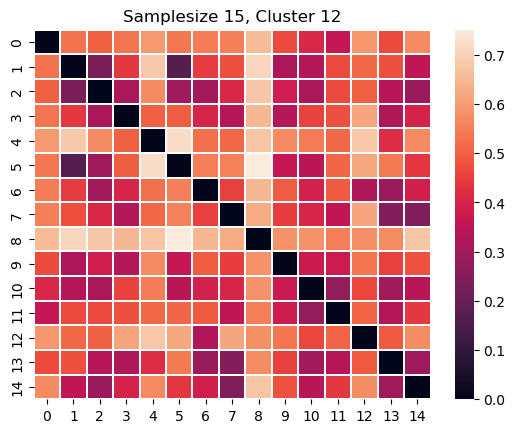

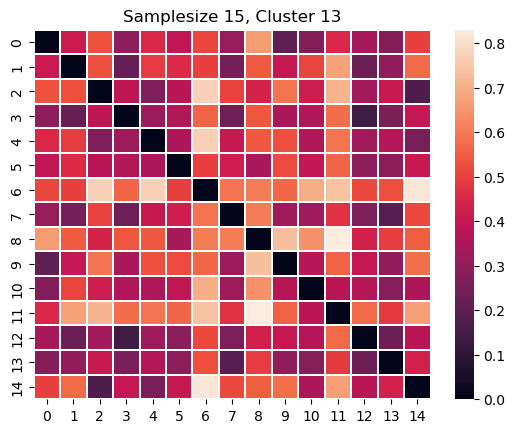

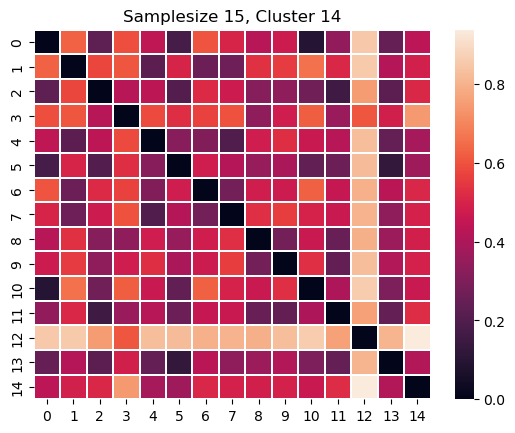

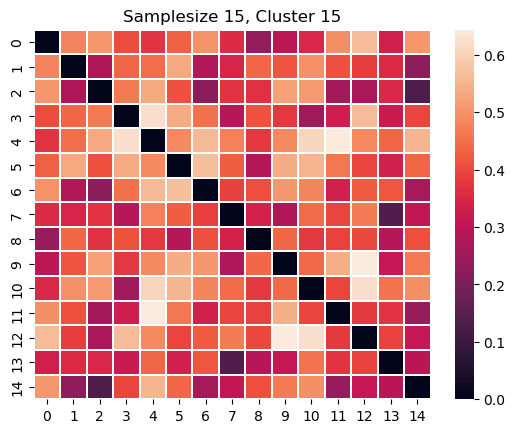

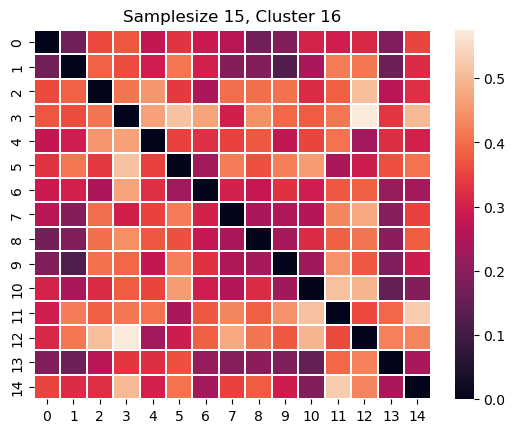

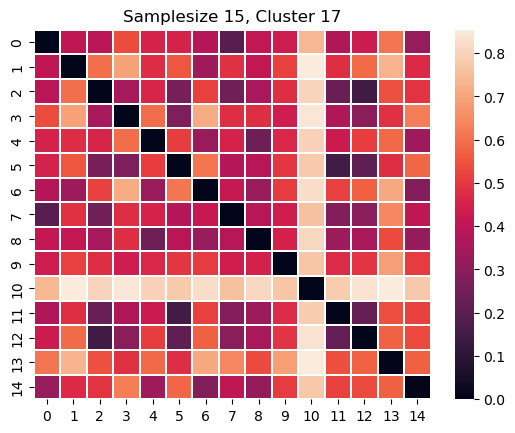

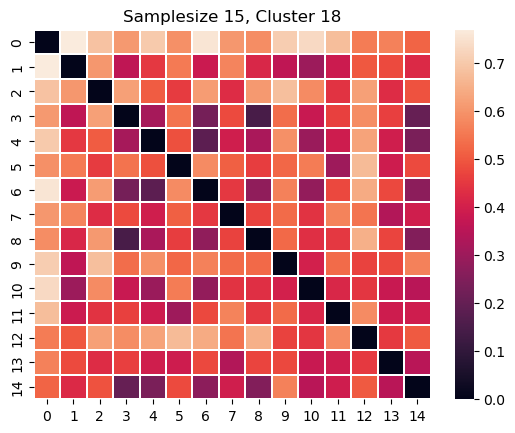

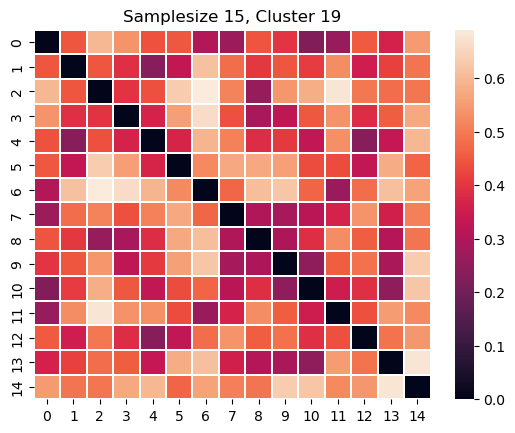

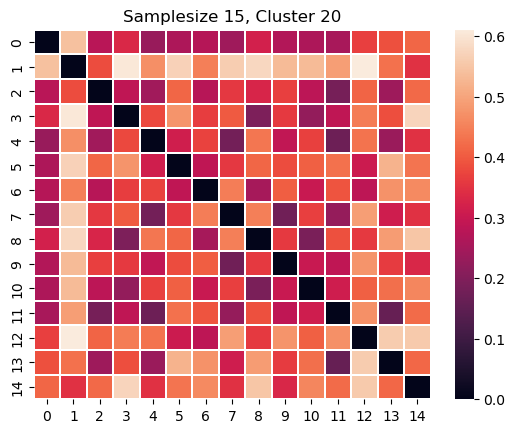

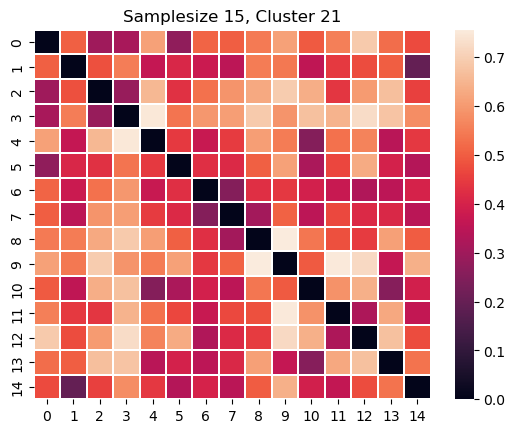

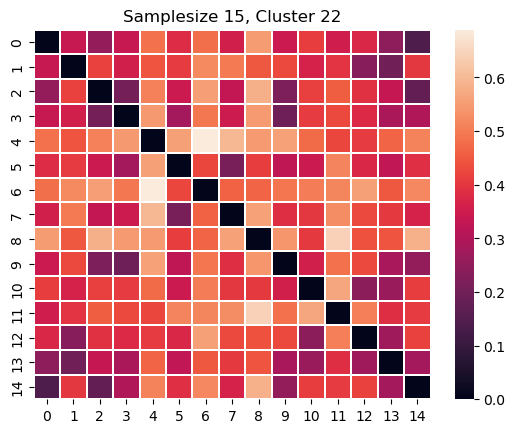

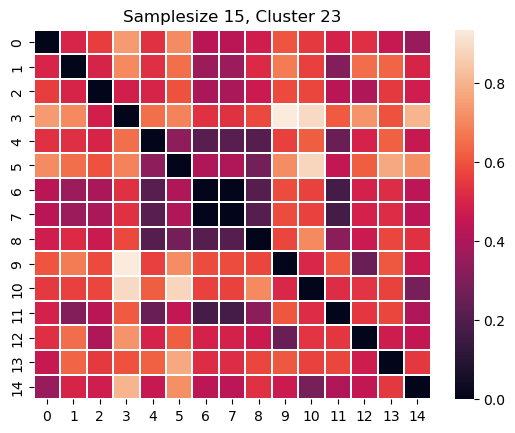

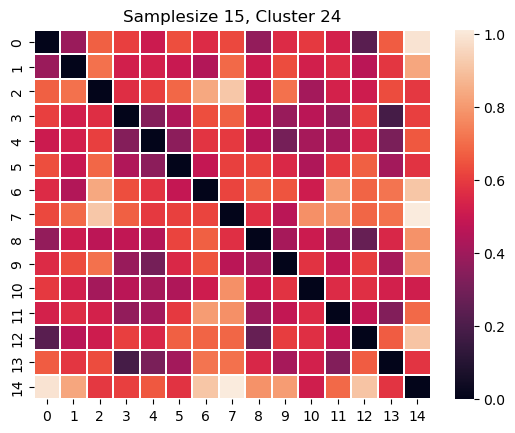

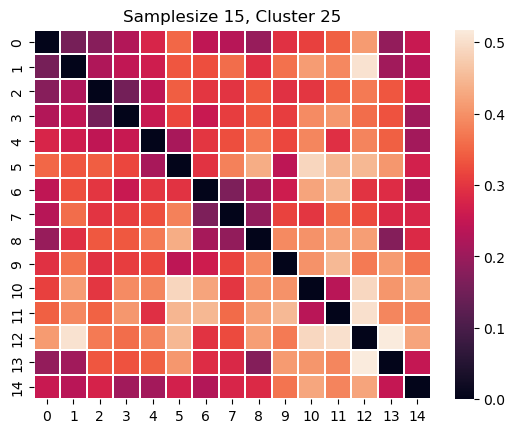

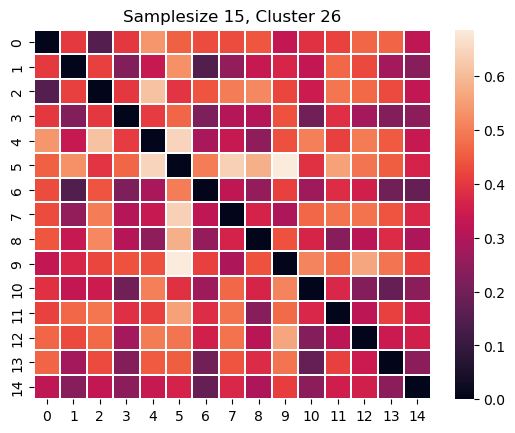

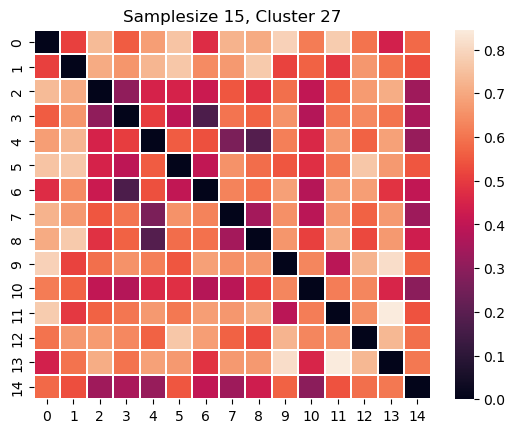

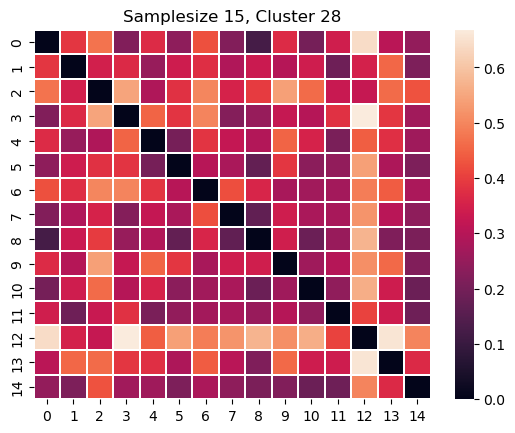

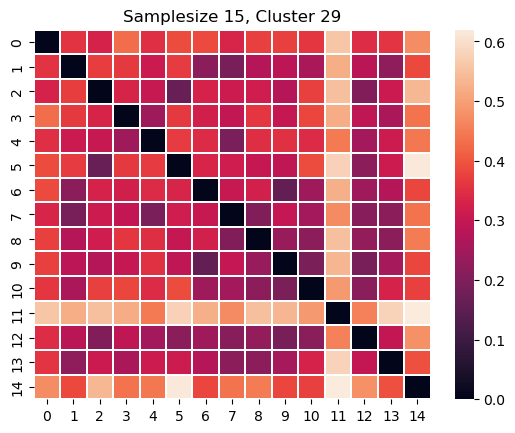

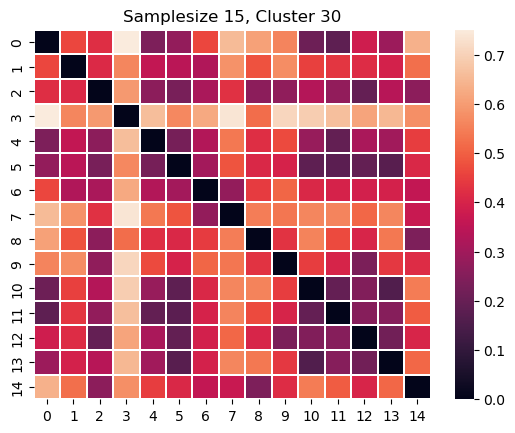

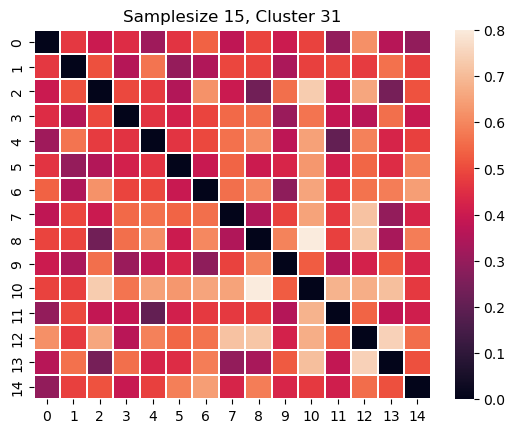

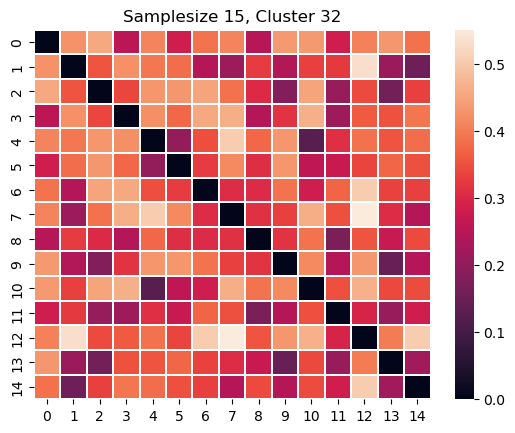

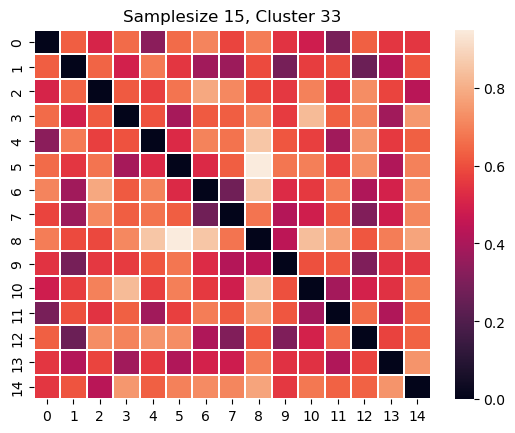

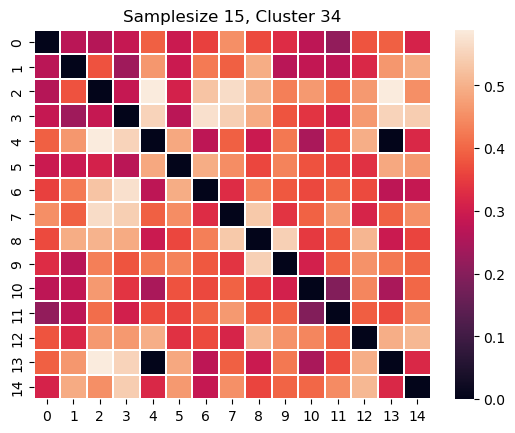

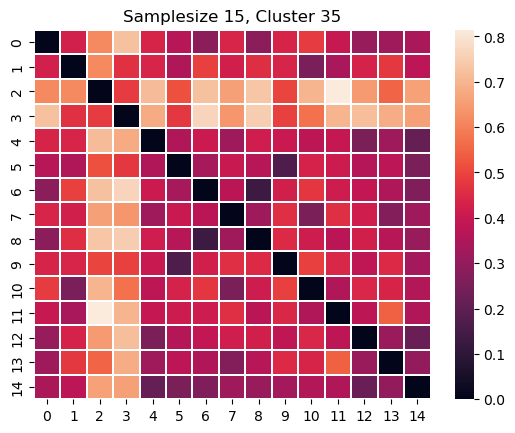

In [19]:
for i in range(len(x_e_list)):
    sns.heatmap(x_e_list[i], linewidths=.2).set_title(f"Samplesize 15, Cluster {i}");
    plt.show()

In [20]:
sample_list_full_df[20]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Nicky Romero,Only for Your Love,0.656670,0.687,0.000000,0.904177,0.033115,0.000184,0.065787,0.195939,0.598051,20
Kelly Clarkson,Because of You,0.602896,0.580,0.454545,0.890173,0.034749,0.243976,0.000000,0.120812,0.653395,20
Becky G,Shower,0.722854,0.529,0.181818,0.855075,0.053050,0.031827,0.000036,0.122843,0.560713,20
Midnight Oil,Beds Are Burning - Remastered,0.778697,0.427,0.000000,0.796974,0.042157,0.007902,0.000660,0.299492,0.556942,20
Lil Jon & The East Side Boyz,Get Low,0.538780,0.625,0.090909,0.856346,0.072985,0.030221,0.000000,0.138071,0.472073,20
"Royce Da 5'9""",Writer's Block (feat. Eminem),0.474664,0.705,0.000000,0.881093,0.137255,0.000411,0.000002,0.209137,0.734670,20
Bad Bunny,Si Estuviésemos Juntos,0.694933,0.594,0.090909,0.867057,0.085948,0.062851,0.000052,0.160406,0.803094,20
Herbert Grönemeyer,Stück vom Himmel,0.554292,0.692,0.000000,0.891624,0.036710,0.089759,0.000000,0.240609,0.415758,20
TEY,Warum liebst du mich,0.799380,0.502,0.000000,0.829415,0.067211,0.064859,0.000003,0.323858,0.719178,20


In [22]:
sample_list_full_df[24]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Oscar Peterson Trio,All the Things You Are,0.621510,0.314,0.454545,0.702259,0.038453,0.528112,0.891371,0.320812,0.634198,24
King Tubby,Take Five,0.742503,0.341,0.727273,0.802533,0.115468,0.515060,0.957360,0.494416,0.743278,24
Joe Henderson,Blue Bossa - Remastered,0.549121,0.366,0.454545,0.787438,0.054031,0.914659,0.893401,0.796954,0.382574,24
Cannonball Adderley,O Amor Em Paz,0.705274,0.281,0.818182,0.773744,0.037146,0.976908,0.897462,0.442640,0.551928,24
Wes Montgomery,A Day In The Life,0.492244,0.251,0.818182,0.752274,0.030283,0.772088,0.785787,0.375635,0.461858,24
The Monty Alexander Trio,Monticello,0.578077,0.479,1.000000,0.682208,0.046732,0.680723,0.874112,0.492386,0.466293,24
Daft Punk,Something About Us,0.904860,0.475,0.818182,0.771527,0.107407,0.441767,0.730964,0.389848,0.467115,24
Angel Olsen,Unfucktheworld,0.573940,0.717,0.727273,0.811646,0.073638,0.729920,0.703553,0.070761,0.594551,24
Toots Thielemans,Stars Fell On Alabama,0.531541,0.409,0.454545,0.809543,0.068301,0.813253,0.781726,0.445685,0.651110,24


In [23]:
sample_list_full_df[25]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Boyzone,Picture Of You,0.794209,0.919,0.000000,0.879234,0.045316,0.109438,0.000001,0.875127,0.545114,25
Flo Rida,Whistle,0.779731,0.933,0.000000,0.883799,0.048802,0.019980,0.000000,0.761421,0.485967,25
CeeLo Green,Fuck You,0.716649,0.879,0.000000,0.913110,0.062963,0.193775,0.000000,0.764467,0.595621,25
Lionel Richie,Dancing On The Ceiling,0.721820,0.774,0.000000,0.837240,0.052288,0.120482,0.000002,0.742132,0.622445,25
Kesha,TiK ToK,0.780765,0.837,0.181818,0.933814,0.154684,0.099498,0.000000,0.724873,0.560905,25
Katy Perry,Last Friday Night (T.G.I.F.),0.671148,0.815,0.272727,0.916240,0.045207,0.001255,0.000044,0.776650,0.588953,25
MAGIC!,Rude,0.799380,0.758,0.090909,0.896727,0.041503,0.042369,0.000000,0.939086,0.673083,25
Culcha Candela,Monsta,0.873837,0.782,0.090909,0.911871,0.034532,0.172691,0.000000,0.975635,0.621749,25
M People,Moving on Up,0.929679,0.857,0.000000,0.878224,0.040305,0.050100,0.030355,0.975635,0.584476,25


In [24]:
sample_list_full_df[26]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Sentenced,The War Ain't Over!,0.205791,0.989,0.090909,0.869714,0.397603,0.003102,0.029340,0.098985,0.716052,26
Morbid Saint,Lock up Your Children,0.306101,0.991,0.090909,0.846777,0.096950,0.000043,0.141117,0.049949,0.498107,26
Massacra,Enjoy the Violence,0.253361,0.988,0.000000,0.858743,0.325708,0.000140,0.002437,0.095431,0.794056,26
Vader,Shadowfear,0.264736,0.930,0.090909,0.963206,0.075054,0.000005,0.096548,0.210152,0.561676,26
Imprecation,Nocturnal Feast of the Luciferians,0.210962,0.911,0.363636,0.776385,0.112200,0.001566,0.087411,0.080406,0.376032,26
Vader,Final Massacre,0.198552,0.744,0.090909,0.772652,0.097930,0.000103,0.065584,0.149239,0.931758,26
Morgoth,The Art of Sinking,0.359876,0.935,0.181818,0.835724,0.072222,0.000069,0.086904,0.101117,0.518847,26
Sentenced,Suffocated Beginning of Life - remastered 2008,0.168563,0.940,0.090909,0.883538,0.223312,0.000027,0.192893,0.116751,0.365438,26
Dismember,Dismembered,0.286453,0.971,0.363636,0.886358,0.168845,0.000003,0.097970,0.220305,0.508725,26


In [25]:
sample_list_full_df[27]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Dusty Springfield,Son of a Preacher Man,0.418821,0.488,0.363636,0.802321,0.073856,0.416667,0.000000,0.818274,0.848750,27
Academia da Berlinda,Carro do Gás,0.427094,0.572,0.000000,0.829676,0.039978,0.578313,0.256853,0.982741,0.832567,27
Elvis Presley,Don't Be Cruel,0.720786,0.550,0.181818,0.790714,0.194989,0.859438,0.000035,0.856853,0.396290,27
Stan Getz,Menina Moca,0.613237,0.475,0.363636,0.802664,0.036601,0.800201,0.000379,0.801015,0.497691,27
-M-,Solidarité,0.779731,0.777,0.272727,0.852564,0.147059,0.503012,0.000000,0.912690,0.385130,27
Augustus Pablo,East of the River Nile - 1971 Version,0.869700,0.547,0.454545,0.836458,0.065468,0.848394,0.259898,0.856853,0.527370,27
Lloyd Price,Personality,0.611169,0.454,0.454545,0.832448,0.035076,0.746988,0.000000,0.878173,0.602407,27
Seu Jorge,Burguesinha,0.705274,0.949,0.181818,0.890075,0.045861,0.565261,0.004091,0.974619,0.476546,27
Wisin & Yandel,Pegao,0.819028,0.816,0.272727,0.900672,0.277778,0.512048,0.000000,0.821320,0.448797,27


In [26]:
sample_list_full_df[28]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Gorguts,Orphans of Sickness,0.217166,0.917,0.090909,0.846630,0.114379,0.000007,0.311675,0.376650,0.412314,28
Morbid Angel,Heaving Earth,0.347466,0.981,0.090909,0.841691,0.174292,0.003574,0.564467,0.219289,0.606767,28
Disincarnate,Beyond the Flesh,0.152017,0.924,0.181818,0.865850,0.099891,0.000005,0.408122,0.128934,0.782303,28
Mortification,"Butchered Mutilation ( Bonus Track,1993)",0.349535,0.945,0.090909,0.838382,0.083551,0.000027,0.420305,0.500508,0.449353,28
Vader,The Red Passage,0.310238,0.997,0.181818,0.901014,0.174292,0.000320,0.379695,0.098579,0.570541,28
Necrophobic,Unholy Prophecies,0.201655,0.981,0.181818,0.908872,0.164488,0.000324,0.350254,0.184772,0.427198,28
Behemoth,Lam,0.144778,0.919,0.181818,0.920625,0.165577,0.000007,0.622335,0.140102,0.340413,28
Vader,Vision and the Voice,0.246122,0.933,0.181818,0.896042,0.098148,0.000009,0.414213,0.394924,0.573676,28
Sentenced,Wings,0.218201,0.924,0.181818,0.845440,0.114379,0.000005,0.355330,0.320812,0.448002,28


In [28]:
sample_list_full_df[29]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
The Ganja Kru,Super Sharp Shooter,0.691830,0.753,0.181818,0.808793,0.244009,0.018675,0.043147,0.452792,0.765840,29
Calvin Harris,Outside (feat. Ellie Goulding),0.668046,0.823,0.181818,0.910909,0.042919,0.213855,0.000000,0.424365,0.598322,29
David Archuleta,Crush,0.589452,0.664,0.000000,0.901210,0.035076,0.008394,0.000012,0.494416,0.757437,29
Calvin Harris,Blame (feat. John Newman),0.426060,0.859,0.000000,0.911349,0.092593,0.028313,0.007777,0.372589,0.597836,29
Bruce Springsteen,Dancing In the Dark,0.544984,0.942,0.090909,0.886179,0.039869,0.011546,0.000000,0.502538,0.695000,29
U2,Sweetest Thing - The Single Mix,0.552223,0.605,0.000000,0.862443,0.038344,0.094478,0.000044,0.566497,0.664704,29
B Fachada,É Normal,0.680455,0.785,0.000000,0.839343,0.039216,0.181727,0.002264,0.350254,0.584210,29
Alesso,Sweet Escape,0.591520,0.839,0.181818,0.915115,0.043246,0.072390,0.000002,0.523858,0.588948,29
Adele,Set Fire to the Rain,0.630817,0.683,0.181818,0.914887,0.027560,0.003835,0.000002,0.473096,0.504711,29


In [29]:
sample_list_full_df[30]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Deicide,Dead by Dawn,0.256463,0.993,1.000000,0.898129,0.205882,0.000057,0.021218,0.101320,0.864218,30
Showtek,Booyah - Radio Edit,0.578077,0.916,1.000000,0.928401,0.068192,0.045482,0.000013,0.197970,0.598215,30
Brutality,When the Sky Turns Black,0.232678,0.912,1.000000,0.832578,0.097495,0.000166,0.176650,0.218274,0.522852,30
The Easybeats,Friday On My Mind,0.386763,0.991,0.818182,0.960174,0.088562,0.381526,0.000730,0.517766,0.444437,30
Sepultura,Desperate Cry,0.327818,0.904,1.000000,0.857960,0.155773,0.000008,0.163452,0.192893,0.758764,30
Opprobrium,Ancient Rebellion,0.267839,0.947,0.909091,0.876316,0.147059,0.000012,0.016853,0.198985,0.633988,30
Morbid Angel,Blessed Are The Sick / Leading the Rats,0.361944,0.698,1.000000,0.831518,0.056645,0.003253,0.001614,0.224365,0.593018,30
Alice Coltrane,Journey In Satchidananda,0.190279,0.543,1.000000,0.756692,0.042593,0.016064,0.000000,0.214213,0.459835,30
Deicide,Dead but Dreaming,0.311272,0.937,1.000000,0.855385,0.090741,0.000006,0.258883,0.439594,0.441142,30


In [30]:
sample_list_full_df[31]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Echt,Weinst Du,0.399173,0.490,0.454545,0.803528,0.034641,0.484940,0.000000,0.220305,0.605846,31
Crystal Gayle,Don't It Make My Brown Eyes Blue,0.698035,0.490,0.545455,0.850673,0.043028,0.716867,0.000318,0.358376,0.394453,31
Meat Loaf,I'd Do Anything For Love (But I Won't Do That) - Single Edit,0.433299,0.672,0.181818,0.874556,0.100218,0.625502,0.000000,0.308629,0.491668,31
Jackie McLean,Blues Inn - Remastered,0.602896,0.461,0.454545,0.821949,0.052505,0.670683,0.172589,0.523858,0.616281,31
Jessie J,"Flashlight - From ""Pitch Perfect 2"" Soundtrack",0.473630,0.623,0.454545,0.862231,0.055011,0.323293,0.000005,0.423350,0.689915,31
Trueno,Mamichula - con Nicki Nicole,0.719752,0.678,0.363636,0.882055,0.080065,0.584337,0.000002,0.351269,0.429857,31
SDP,Ich will nur dass du weißt - Radio Edit,0.637022,0.690,0.727273,0.884402,0.044771,0.531124,0.000000,0.458883,0.383195,31
Mariah Carey,"I'll Be There (feat. Trey Lorenz) - Live at MTV Unplugged, Kaufman Astoria StuLive at MTV Unplugged, Kaufman Astoria Studios, New York - March 1992dios, New York - March 1992",0.223371,0.544,0.454545,0.845554,0.046950,0.665663,0.000000,0.305584,0.350563,31
Ike & Tina Turner,River Deep - Mountain High,0.402275,0.745,0.272727,0.864041,0.041830,0.780120,0.001614,0.275127,0.388041,31


In [31]:
sample_list_full_df[32]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Lizzy Mercier Descloux,Fire,0.574974,0.863,0.727273,0.896237,0.035512,0.019980,0.191878,0.823350,0.514038,32
Zion & Lennox,Otra vez (feat. J Balvin),0.860393,0.772,0.909091,0.889619,0.108932,0.056124,0.000493,0.714721,0.448694,32
P!nk,Get the Party Started,0.829369,0.903,1.000000,0.924864,0.050109,0.001104,0.000000,0.974619,0.602505,32
Katrina & The Waves,Walking On Sunshine,0.616339,0.869,0.909091,0.782987,0.040305,0.011647,0.175635,0.958376,0.513585,32
Unheilig,Für immer,0.580145,0.900,1.000000,0.884663,0.048693,0.002098,0.000071,0.627411,0.644829,32
Sportfreunde Stiller,"'54, '74, '90, 2006",0.568769,0.925,0.818182,0.888086,0.084423,0.041265,0.000000,0.689340,0.616814,32
Swedish House Mafia,One (Your Name) - Radio Edit,0.758014,0.673,0.818182,0.870986,0.036275,0.013253,0.004975,0.645685,0.584425,32
J Balvin,Qué Más Pues?,0.921406,0.819,0.727273,0.913501,0.115468,0.026205,0.000359,0.779695,0.476508,32
The Rolling Stones,(I Can't Get No) Satisfaction - Mono Version,0.755946,0.837,0.818182,0.836735,0.051961,0.000288,0.152284,0.844670,0.633688,32


In [32]:
sample_list_full_df[33]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Origin Unknown,Valley of the Shadows,0.673216,0.770,0.545455,0.810896,0.063181,0.045582,0.882234,0.527919,0.746867,33
INXS,Need You Tonight,0.822130,0.630,0.909091,0.860471,0.091612,0.042068,0.583756,0.796954,0.507972,33
Mariah,Shinzo No Tobira,0.688728,0.752,0.727273,0.890744,0.042593,0.470884,0.790863,0.469036,0.593874,33
The Temper Trap,Sweet Disposition (Axwell Mix),0.703206,0.722,1.000000,0.881403,0.055229,0.021687,0.481218,0.359391,0.598131,33
Bolt Thrower,Anti-Tank (Dead Armour),0.459152,0.871,0.545455,0.856037,0.048584,0.000002,0.743147,0.462944,0.588593,33
Justice,We Are Your Friends - Justice Vs Simian,0.635988,0.970,0.818182,1.000000,0.129630,0.010442,0.389848,0.514721,0.574761,33
Marilyn Manson,The Beautiful People,0.642192,0.834,0.909091,0.813994,0.060675,0.000782,0.462944,0.951269,0.672802,33
T-Power Vs. MK Ultra,Mutant Jazz,0.651499,0.704,0.909091,0.826905,0.089325,0.004618,0.670051,0.914721,0.784224,33
Steve Angello,Be - Instrumental,0.781799,0.349,1.000000,0.790111,0.063834,0.268072,0.972589,0.586802,0.607505,33


In [33]:
sample_list_full_df[34]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Fleetwood Mac,Everywhere,0.713547,0.540,0.363636,0.806690,0.034532,0.218876,0.006670,0.775635,0.536689,34
Marvin Gaye,It Takes Two,0.540848,0.480,0.272727,0.800055,0.053595,0.214859,0.000000,0.822335,0.707510,34
Bee Gees,How Deep Is Your Love,0.654602,0.357,0.454545,0.825438,0.028758,0.105422,0.000000,0.684264,0.490387,34
The Beach Boys,Don't Worry Baby - Remastered 2001,0.503619,0.464,0.363636,0.818020,0.032680,0.066867,0.005391,0.863959,0.566578,34
Jimmy Cliff,You Can Get It If You Really Want,0.924509,0.559,0.090909,0.838789,0.061874,0.248996,0.000000,0.943147,0.598925,34
Thin Lizzy,Dancing In The Moonlight (It's Caught Me In It's Spotlight),0.693899,0.461,0.363636,0.751948,0.141612,0.007580,0.000000,0.795939,0.678476,34
Bausa,Was du Liebe nennst,0.903826,0.487,0.181818,0.845196,0.069826,0.394578,0.000030,0.757360,0.677396,34
Bunny Wailer,Fighting Against Conviction,0.748707,0.393,0.090909,0.769310,0.294118,0.314257,0.036751,0.798985,0.701280,34
Laing,Morgens immer müde - Single Version,0.963806,0.581,0.272727,0.835904,0.048475,0.026807,0.008122,0.913706,0.607528,34


In [34]:
sample_list_full_df[35]

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,valence,tempo,cluster
artist,name,,,,,,,,,,
Bad Bunny,Sensualidad,0.834540,0.681,1.000000,0.875941,0.107081,0.424699,0.000000,0.686294,0.654264,35
Ben,Engel (feat. Gim) - Radio Edit,0.616339,0.747,0.909091,0.848489,0.254902,0.391566,0.000000,0.456853,0.443553,35
Missy Elliott,I'm Better (feat. Lamb),0.957601,0.354,0.909091,0.802501,0.556645,0.375502,0.000000,0.569543,0.490701,35
MiMS,This Is Why I'm Hot,0.642192,0.600,0.727273,0.874621,0.627451,0.278112,0.000000,0.492386,0.373947,35
Lighthouse Family,High,0.686660,0.622,0.909091,0.839474,0.027560,0.099799,0.074924,0.623350,0.478256,35
Maluma,11 PM,0.803516,0.712,0.909091,0.899221,0.301743,0.217871,0.000000,0.690355,0.447180,35
Becky G,Sin Pijama,0.817994,0.745,1.000000,0.917887,0.050545,0.355422,0.000030,0.832487,0.439338,35
The Corrs,What Can I Do,0.652534,0.516,0.818182,0.855629,0.038126,0.337349,0.000000,0.698477,0.364503,35
Britney Spears,Sometimes,0.770424,0.742,0.909091,0.885315,0.028214,0.421687,0.000000,0.818274,0.448600,35
